## Image classification using convolutional neural networks

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import tarfile
from torchvision.datasets.utils import download_url

In [30]:
project_name="5_cifar10"

### Download and setup dataset

In [32]:

dataset_url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,"./data")

In [33]:
with tarfile.open("./data/cifar10.tgz","r:gz") as tar:
    tar.extractall(path="./data")

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_23840\1800157065.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="./data")


In [34]:
import os
print(os.listdir("./data/cifar10"))
print(os.listdir("./data/cifar10/train"))

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [35]:
print(len(os.listdir("./data/cifar10/train/cat")))

5000


this directory structure is used by many datasets,pytorch provide a utility ImageFolder

In [37]:
from torchvision.datasets import ImageFolder
dataset=ImageFolder("./data/cifar10/train",transform=transforms.ToTensor())

In [38]:
print(len(dataset))
dataset[0]

50000


(tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
          [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
          [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
          ...,
          [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
          [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
          [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],
 
         [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
          [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
          [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
          ...,
          [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
          [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
          [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],
 
         [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
          [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
          [0.8118, 0.8157, 0.8235,  ...,

In [39]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 32, 32])


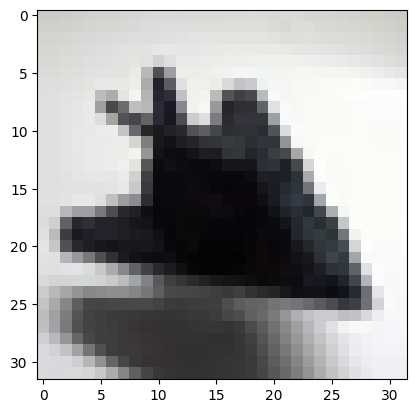

In [40]:
image,label=dataset[0]
print(image.shape)
plt.imshow(image.permute(1,2,0))

Training set-Used to train and compute loss and adjust weights of the model   
Validation_set-Used to evaluate the model while training,adjust hyperparameters and pick the best version of model  
Test set-used to compare different models or different modelling approches adn report final accuracy of the model  

In [42]:
#create train and validation spilt

train_ds,val_ds=random_split(dataset,[40000,10000])

In [43]:
#create dataLoaders
train_dl=DataLoader(train_ds,batch_size=128,num_workers=4,pin_memory=True,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=128,num_workers=4,pin_memory=True)

In [44]:
test_ds=ImageFolder("./data/cifar10/test",transform=transforms.ToTensor())
test_dl=DataLoader(test_ds,batch_size=256,num_workers=4,pin_memory=True)

In [45]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

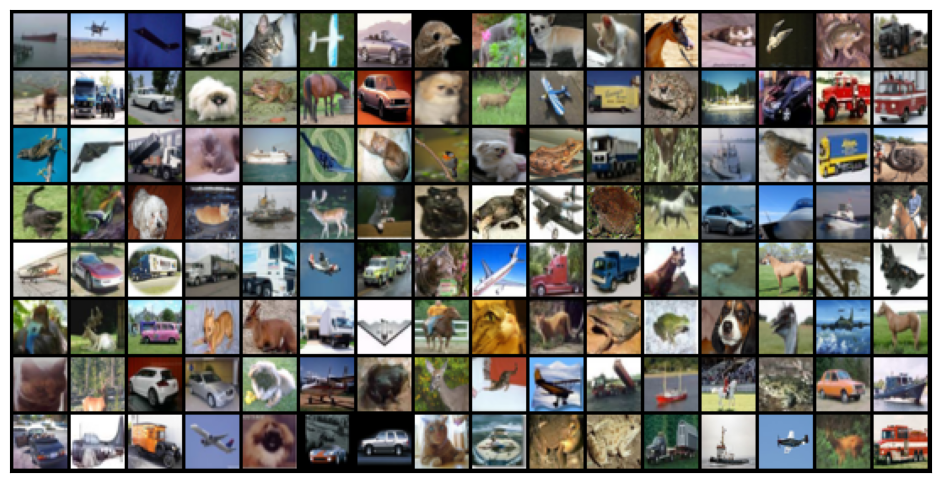

In [46]:
show_batch(train_dl)

### Defining the Model (convolutional neural network)

<b>Convolution</b>  
-> kernel is small matrix of weights.this kernel slides over the 2D input data ,performing an elementwise multiplication with the part of the input it is currently on,and then summing up the results into a single output pixel    
-> for multichannel images, a diffent kernel is applied to each channels, and the outputs(feature maps) are added together pixel wise,we get output map  
->the output maps are new channels  
->no of kernels== no of new channels  
->trying to increse the no of channels by using kernels  
->as edges covering fewer times than other pixels by kernels we add padding <i>(if padding=1 then input dim=ouput dim)</i> 
 
->RESOURCE  
1.intuitively understanding convolutions for deep learning by irhum shafkat    
2.convolutions in depth by sylvian gugger   

<b>Pooling</b>  
we want an output with lower size than the input.so,reduce size of spatial dimensions when number of channels increses.one way of accomplish this is by using pooling layer(eg:taking the average/max of every 2X2 grid to reduce each spatial dimensions in half) and another way is stride  
-> to move kernel more then one position at a time we add stride 

Advantages of CNN  
-fewer parameters  
-sparsity of connections:In each layer,each otp element only depends on small num of inputs elements which makes the forward and backward pass more efficient  
-parameter sharing and spatial invariance: the features learned by kernel in one part of the image can be used to detect similar pattern in a differnt  part of another image

In [51]:
conv=nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1) #input channel ,output channel/num_kernels
pool=nn.MaxPool2d(2,2)
for images,labels in train_dl:
    print(images.shape)
    out=conv(images)
    print(out.shape)
    out=pool(out)
    print(out.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 32, 32])
torch.Size([128, 8, 16, 16])


In [52]:
conv.weight #diff weights for diff channel 

Parameter containing:
tensor([[[[ 0.1252, -0.0060, -0.1859],
          [-0.0660,  0.1080,  0.1830],
          [-0.1364, -0.0127,  0.0033]],

         [[ 0.0487,  0.0562,  0.1591],
          [ 0.0269, -0.0976,  0.0744],
          [ 0.1743, -0.0058,  0.0587]],

         [[-0.1858,  0.1298, -0.1779],
          [-0.1015,  0.0271,  0.0555],
          [ 0.0544, -0.0613, -0.1700]]],


        [[[ 0.1896,  0.1752, -0.0117],
          [-0.0552, -0.0381,  0.0096],
          [ 0.1499, -0.0846, -0.1493]],

         [[ 0.0308, -0.1713, -0.1473],
          [ 0.0762,  0.0192,  0.0909],
          [ 0.1472, -0.0939,  0.1788]],

         [[-0.0524, -0.0475,  0.0202],
          [-0.1360,  0.1242, -0.0664],
          [ 0.1098, -0.0822,  0.0212]]],


        [[[ 0.1001, -0.0595,  0.0926],
          [ 0.0915,  0.0024,  0.1355],
          [ 0.0690, -0.0399,  0.0936]],

         [[ 0.1118, -0.1823, -0.0669],
          [-0.1034, -0.0807,  0.1645],
          [-0.1458, -0.1262,  0.1319]],

         [[-0.1404, -0

the conv2d layer transforms a 3 channel image to n-channel feature map and the maxpool layer halves the height and width.the feature map gets smaller as we add more layers until we are finlly left with a small feature map,which can be flattened into vector.we can then add some fully connected layers at the end to get vector of size 10 for each image

In [54]:
#image classification base
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"],result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [55]:
class Cifar10cnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            #input 3X32X32
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            #output 32X32X32
            nn.ReLU(),
            #output 32X32X32
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            #output 64X32X32
            nn.ReLU(),
            #output 64X32X32
            nn.MaxPool2d(2,2),#64X16X16

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#128X8X8

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#256X4X4

            nn.Flatten(),
            nn.Linear(256*4*4,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,10))
    def forward(self,xb):
        return self.network(xb)
   

In [56]:
model=Cifar10cnnModel()
model

Cifar10cnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

### Using GPU


In [58]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [59]:
device=get_default_device()
device

device(type='cuda')

In [60]:
def to_device(data,device):
    if(isinstance(data,(list,tuple))):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [61]:
class Device_Data_Loader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,device)
    def __len__(self):
        return len(self.dl)
        
        

In [62]:
train_dl=Device_Data_Loader(train_dl,device)
val_dl=Device_Data_Loader(val_dl,device)

### Training

In [64]:
def fit(epochs,lr,model,train_dl,val_dl,opt_fn=torch.optim.SGD):
    opt_fn=opt_fn(model.parameters(),lr)
    history=[]
    
    #training phase
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            opt_fn.step()
            opt_fn.zero_grad()
        #validation phase
        result=evaluate(model,val_dl)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [65]:
@torch.no_grad()
def evaluate(model,val_dl):
    model.eval()
    outputs= [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [66]:
model=to_device(model,device)

In [67]:
hist=[evaluate(model,val_dl)]
print(hist)

[{'val_loss': 2.303178548812866, 'val_acc': 0.09661787748336792}]


In [68]:
for images,labels in train_dl:
    print(images.shape)
    out=model(images)
    print(out.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [69]:
num_epochs=10
opt_func=torch.optim.Adam
lr=0.001

In [70]:
hist=fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss:1.8142 val_loss: 1.5319, val_acc: 0.4316
Epoch [1], train_loss:1.2993 val_loss: 1.1252, val_acc: 0.5941
Epoch [2], train_loss:1.0125 val_loss: 0.9535, val_acc: 0.6568
Epoch [3], train_loss:0.8101 val_loss: 0.8340, val_acc: 0.7061
Epoch [4], train_loss:0.6674 val_loss: 0.7680, val_acc: 0.7302
Epoch [5], train_loss:0.5392 val_loss: 0.7302, val_acc: 0.7519
Epoch [6], train_loss:0.4191 val_loss: 0.7313, val_acc: 0.7593
Epoch [7], train_loss:0.3217 val_loss: 0.7685, val_acc: 0.7669
Epoch [8], train_loss:0.2256 val_loss: 0.8869, val_acc: 0.7661
Epoch [9], train_loss:0.1702 val_loss: 0.9763, val_acc: 0.7611


In [71]:
def plot_Accuracies(history):
    plt.plot([x["val_acc"] for x in history])
    plt.title("acc vs num_epochs")

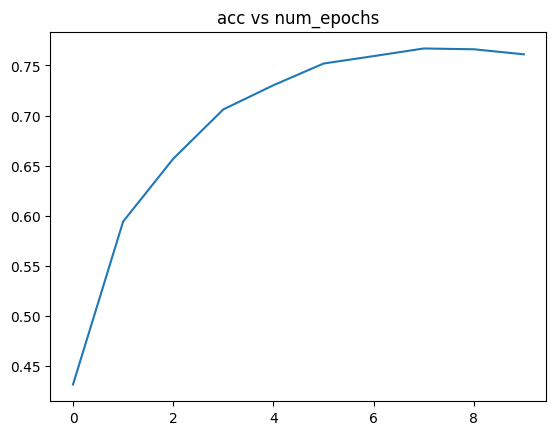

In [72]:
plot_Accuracies(hist)

In [73]:
def plot_losses(history):
    train_losses=[x["train_loss"] for x in history]
    val_losses=[x["val_loss"] for x in history]
    plt.plot(train_losses,"-bx")
    plt.plot(val_losses,"-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training","Validation"])
    plt.title("loss vs No of epochs")

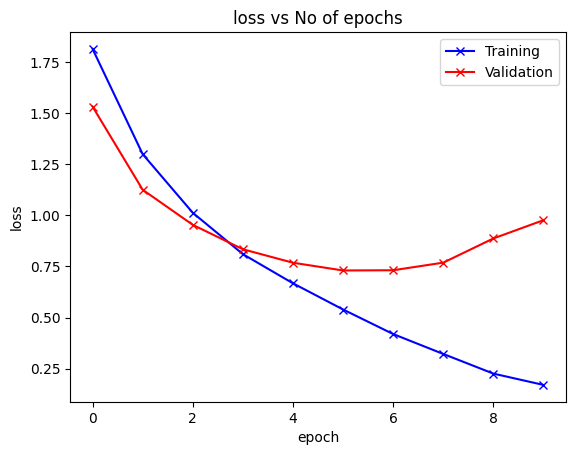

In [74]:
plot_losses(hist)


here overfitting occur  
- gathering and generating more dat  
-regularization  
-early stopping


## Prediction

In [87]:
def predict(model,image):
    image=to_device(image.unsqueeze(0),device)
    out=model(image)
    _,pred=torch.max(out,dim=1)
    return dataset.classes[pred[0].item()]

bird
2


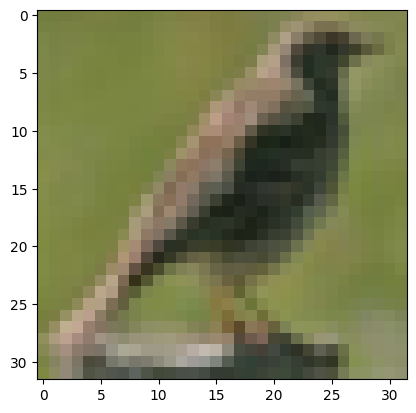

In [89]:
image,label=train_ds[10]
plt.imshow(image.permute(1,2,0))
print(predict(model,image))
print(label)

## Evaluation

In [92]:
test_ds=ImageFolder("./data/cifar10/test",transform=transforms.ToTensor())

In [94]:
test_dl=DataLoader(test_ds,batch_size=128,num_workers=3,pin_memory=True)
test_dl=Device_Data_Loader(test_dl,device)

In [96]:
evaluate(model,test_dl)

{'val_loss': 1.0188318490982056, 'val_acc': 0.7576147317886353}

In [99]:
torch.save(model.state_dict(),"cifar10-cnn.pth")

In [101]:
model2=to_device(Cifar10cnnModel(),device)

In [103]:
model2.load_state_dict(torch.load("cifar10-cnn.pth"))

<All keys matched successfully>

In [105]:
evaluate(model2,test_dl)

{'val_loss': 1.0188318490982056, 'val_acc': 0.7576147317886353}